In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler


🌟 Exercise 1: Duplicate Detection And Removal

In [2]:

# Load the Titanic training dataset.
# We start by loading the raw data before any preprocessing steps.
df = pd.read_csv("train.csv")

# Store the initial number of rows for comparison later.
rows_before = df.shape[0]


In [3]:
# Check for duplicate rows across all columns.
# duplicated() returns a boolean mask indicating whether a row is a duplicate
# of a previous row.
duplicate_count = df.duplicated().sum()

duplicate_count


np.int64(0)

In [4]:
# Remove duplicate rows from the dataset.
# Even if no duplicates are found, applying drop_duplicates() ensures
# a consistent and robust preprocessing pipeline.
df = df.drop_duplicates()

# Store the number of rows after duplicate removal.
rows_after = df.shape[0]

print("Number of rows before removing duplicates:", rows_before)
print("Number of rows after removing duplicates:", rows_after)


Number of rows before removing duplicates: 891
Number of rows after removing duplicates: 891


In [5]:

# ============================================================
# Exercise 2: Handling Missing Values
# ============================================================

# 1) Identify columns with missing values
missing_counts = df.isnull().sum()
missing_cols = missing_counts[missing_counts > 0].sort_values(ascending=False)

print("Columns with missing values (count):")
print(missing_cols)

print("\nMissing ratio (%):")
print((missing_cols / len(df) * 100).round(2))


# 2) Strategy decisions (commentary)
# - Cabin: too many missing values → dropping the column is more reliable than imputing
# - Age: numeric and important → fill with median (robust to outliers)
# - Embarked: categorical with few missing → fill with mode (most frequent category)


# 3) Handle Cabin (drop if present)
if "Cabin" in df.columns:
    cabin_missing_ratio = df["Cabin"].isnull().mean()
    print(f"\nCabin missing ratio: {cabin_missing_ratio:.2%}")

    # Threshold choice: if > 70% missing, drop the column (imputation would be mostly guesswork)
    if cabin_missing_ratio > 0.70:
        df = df.drop(columns=["Cabin"])
        print("Cabin dropped (too many missing values).")
    else:
        # If your dataset version had less missing data, you'd consider extracting features like Deck.
        print("Cabin not dropped (missing ratio <= 70%).")
else:
    print("\nCabin already removed (skipping).")


# 4) Handle Age (median imputation)
if "Age" in df.columns:
    age_missing_before = df["Age"].isnull().sum()
    print(f"\nMissing Age values before: {age_missing_before}")

    # Median is chosen instead of mean because Age may include outliers,
    # and the median is less sensitive to extreme values.
    age_median = df["Age"].median()
    df["Age"] = df["Age"].fillna(age_median)

    age_missing_after = df["Age"].isnull().sum()
    print(f"Missing Age values after: {age_missing_after}")
    print(f"Age median used: {age_median}")
else:
    print("\nAge column not found (unexpected for Titanic train.csv).")


# 5) Handle Embarked (mode imputation)
if "Embarked" in df.columns:
    embarked_missing_before = df["Embarked"].isnull().sum()
    print(f"\nMissing Embarked values before: {embarked_missing_before}")

    # For categorical features with few missing values,
    # filling with the mode preserves the most common category distribution.
    embarked_mode = df["Embarked"].mode(dropna=True)[0]
    df["Embarked"] = df["Embarked"].fillna(embarked_mode)

    embarked_missing_after = df["Embarked"].isnull().sum()
    print(f"Missing Embarked values after: {embarked_missing_after}")
    print(f"Embarked mode used: {embarked_mode}")
else:
    print("\nEmbarked column not found (unexpected for Titanic train.csv).")


# 6) Final verification
print("\nFinal missing values per column:")
print(df.isnull().sum().sort_values(ascending=False).head(15))


Columns with missing values (count):
Cabin       687
Age         177
Embarked      2
dtype: int64

Missing ratio (%):
Cabin       77.10
Age         19.87
Embarked     0.22
dtype: float64

Cabin missing ratio: 77.10%
Cabin dropped (too many missing values).

Missing Age values before: 177
Missing Age values after: 0
Age median used: 28.0

Missing Embarked values before: 2
Missing Embarked values after: 0
Embarked mode used: S

Final missing values per column:
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64


In [6]:


# ============================================================
# Exercise 3: Feature Engineering
# ============================================================

# --- 1) Family Size feature ---
# FamilySize = passenger + siblings/spouse + parents/children
# This is a common engineered feature for Titanic because family context can affect survival odds.
df["FamilySize"] = df["SibSp"] + df["Parch"] + 1

# Optional but useful: IsAlone flag derived from FamilySize
# We keep it as a simple binary feature (0/1).
df["IsAlone"] = (df["FamilySize"] == 1).astype(int)


# --- 2) Extract Title from Name ---
# Titles (Mr, Mrs, Miss, etc.) capture social status + sometimes age/marital context.
# We'll extract with a simple regex: text between comma and period.
df["Title"] = df["Name"].str.extract(r",\s*([^.]*)\.", expand=False).str.strip()

# Normalize rare titles into broader groups to reduce noise (too many small categories)
# This is a design choice: rare categories can hurt generalization.
title_map = {
    "Mlle": "Miss",
    "Ms": "Miss",
    "Mme": "Mrs",
    "Lady": "Rare",
    "Countess": "Rare",
    "Dona": "Rare",
    "Dr": "Rare",
    "Rev": "Rare",
    "Col": "Rare",
    "Major": "Rare",
    "Capt": "Rare",
    "Sir": "Rare",
    "Jonkheer": "Rare",
    "Don": "Rare",
}

df["Title"] = df["Title"].replace(title_map)

# Check distribution (good practice before encoding)
print("Title distribution:\n", df["Title"].value_counts(), "\n")


# --- 3) Encode categorical variables ---
# We use one-hot encoding for nominal categories (no natural order),
# because label encoding would introduce a fake ordering.
categorical_cols = ["Sex", "Embarked", "Title"]

# drop_first=True helps reduce multicollinearity (dummy variable trap) for linear models.
# For tree models it's not required, but it’s a reasonable default.
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


# --- 4) (Optional) Drop text columns not useful for most models ---
# Name and Ticket are high-cardinality strings and usually not directly used.
# We keep PassengerId sometimes for reference, but it shouldn't be used as a feature.
cols_to_drop_if_exist = ["Name", "Ticket"]
df = df.drop(columns=[c for c in cols_to_drop_if_exist if c in df.columns])

print("Shape after feature engineering & encoding:", df.shape)
df.head()


Title distribution:
 Title
Mr              517
Miss            185
Mrs             126
Master           40
Rare             22
the Countess      1
Name: count, dtype: int64 

Shape after feature engineering & encoding: (891, 17)


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize,IsAlone,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Title_the Countess
0,1,0,3,22.0,1,0,7.2500,2,0,True,False,True,False,True,False,False,False
1,2,1,1,38.0,1,0,71.2833,2,0,False,False,False,False,False,True,False,False
2,3,1,3,26.0,0,0,7.9250,1,1,False,False,True,True,False,False,False,False
3,4,1,1,35.0,1,0,53.1000,2,0,False,False,True,False,False,True,False,False
4,5,0,3,35.0,0,0,8.0500,1,1,True,False,True,False,True,False,False,False


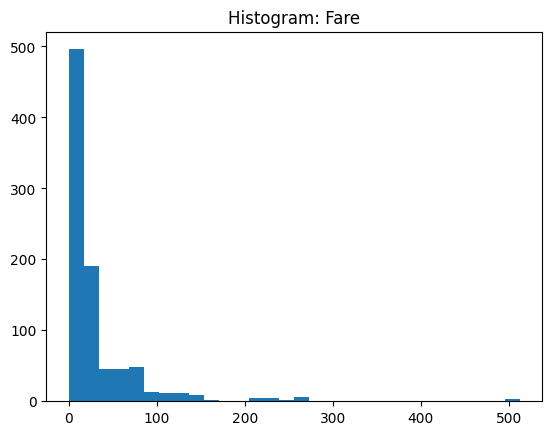

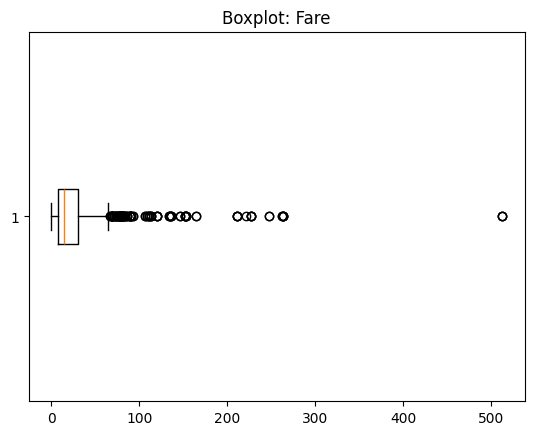

Fare - IQR outliers: 116 | bounds: [-26.724, 65.634]
Fare quantiles: {0.95: 112.07915, 0.98: 211.3375, 0.99: 249.00622000000035} 



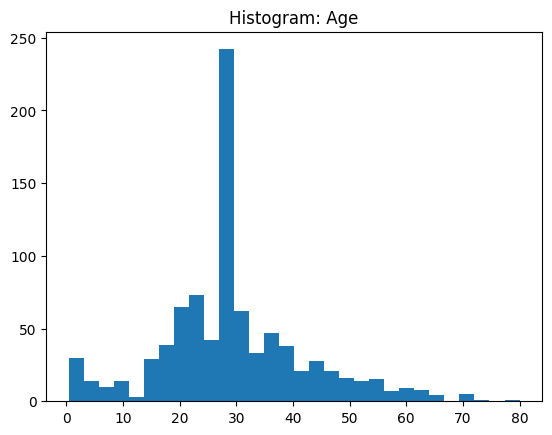

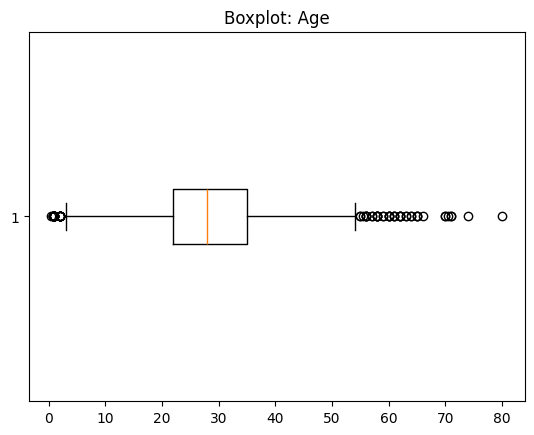

Age - IQR outliers: 66 | bounds: [2.500, 54.500]
Age quantiles: {0.95: 54.0, 0.98: 62.0, 0.99: 65.0} 

Fare_log1p capped to [0.000, 5.521]
Age capped to [1.000, 65.000]


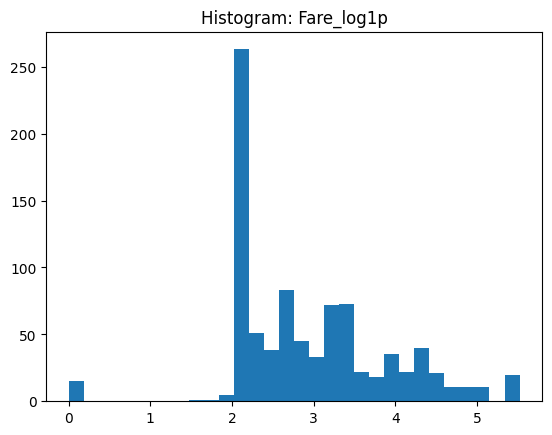

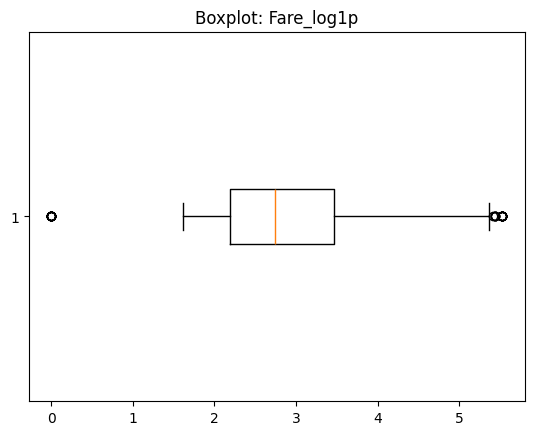

Fare_log1p - IQR outliers: 31 | bounds: [0.269, 5.384]


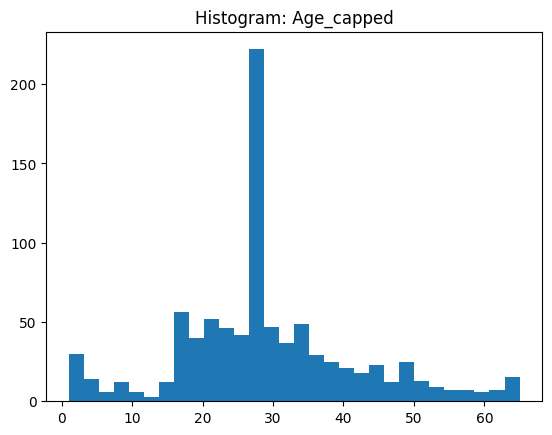

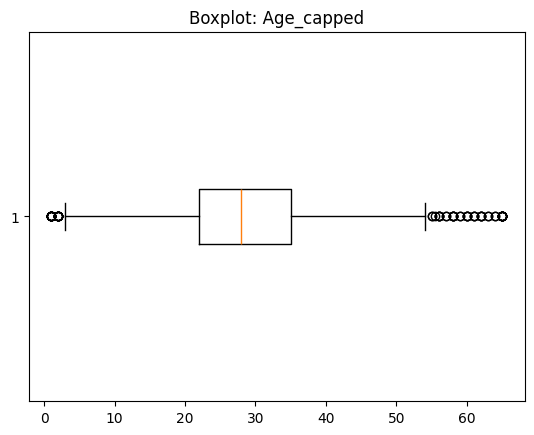

Age_capped - IQR outliers: 66 | bounds: [2.500, 54.500]

Compare describe (before vs after):
Fare before:
 count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64 

Age before:
 count    891.000000
mean      29.361582
std       13.019697
min        0.420000
25%       22.000000
50%       28.000000
75%       35.000000
max       80.000000
Name: Age, dtype: float64 

Fare_log1p after:
 count    891.000000
mean       2.959460
std        0.960734
min        0.000000
25%        2.187218
50%        2.737881
75%        3.465736
max        5.521332
Name: Fare_log1p, dtype: float64 

Age_capped after:
 count    891.000000
mean      29.304714
std       12.832434
min        1.000000
25%       22.000000
50%       28.000000
75%       35.000000
max       65.000000
Name: Age_capped, dtype: float64 



In [7]:
# Exercice 4
# ---------- Helpers ----------
def plot_hist_box(series, title):
    """Quick visual check: histogram + boxplot (matplotlib only)."""
    s = series.dropna()
    fig, ax = plt.subplots()
    ax.hist(s, bins=30)
    ax.set_title(f"Histogram: {title}")
    plt.show()

    fig, ax = plt.subplots()
    ax.boxplot(s, vert=False)
    ax.set_title(f"Boxplot: {title}")
    plt.show()

def iqr_bounds(series, k=1.5):
    """IQR method bounds for outlier detection."""
    s = series.dropna()
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return lower, upper

def count_outliers_iqr(series, k=1.5):
    lower, upper = iqr_bounds(series, k=k)
    return ((series < lower) | (series > upper)).sum(), lower, upper

def cap_by_quantile(series, q_low=0.01, q_high=0.99):
    """Quantile capping to reduce extreme impact without deleting rows."""
    lo = series.quantile(q_low)
    hi = series.quantile(q_high)
    return series.clip(lo, hi), lo, hi


# ---------- BEFORE: visualize + quantify ----------
for col in ["Fare", "Age"]:
    if col in df.columns:
        plot_hist_box(df[col], col)
        n_out, lo, hi = count_outliers_iqr(df[col], k=1.5)
        print(f"{col} - IQR outliers: {n_out} | bounds: [{lo:.3f}, {hi:.3f}]")
        print(f"{col} quantiles:", df[col].quantile([0.95, 0.98, 0.99]).to_dict(), "\n")

# Save snapshot for comparison
df_before_outliers = df.copy()

# ---------- TREATMENT STRATEGY ----------
# Fare: highly skewed -> log1p transform is appropriate.
# Then cap at 0.99 quantile to reduce the influence of rare extreme values.
if "Fare" in df.columns:
    df["Fare_log1p"] = np.log1p(df["Fare"])
    df["Fare_log1p"], fare_lo, fare_hi = cap_by_quantile(df["Fare_log1p"], q_low=0.01, q_high=0.99)
    print(f"Fare_log1p capped to [{fare_lo:.3f}, {fare_hi:.3f}]")

# Age: usually mild extremes -> cap at 0.99 instead of removing rows.
if "Age" in df.columns:
    df["Age_capped"], age_lo, age_hi = cap_by_quantile(df["Age"], q_low=0.01, q_high=0.99)
    print(f"Age capped to [{age_lo:.3f}, {age_hi:.3f}]")

# ---------- AFTER: compare ----------
for col in ["Fare_log1p", "Age_capped"]:
    if col in df.columns:
        plot_hist_box(df[col], col)
        n_out, lo, hi = count_outliers_iqr(df[col], k=1.5)
        print(f"{col} - IQR outliers: {n_out} | bounds: [{lo:.3f}, {hi:.3f}]")

print("\nCompare describe (before vs after):")
print("Fare before:\n", df_before_outliers["Fare"].describe(), "\n")
print("Age before:\n", df_before_outliers["Age"].describe(), "\n")
print("Fare_log1p after:\n", df["Fare_log1p"].describe(), "\n")
print("Age_capped after:\n", df["Age_capped"].describe(), "\n")


🌟 Exercise 5 — Standardization & Normalization (AFTER outliers)

In [8]:

# Identify numeric columns (exclude target)
target_col = "Survived" if "Survived" in df.columns else None

numeric_cols = df.select_dtypes(include=["int64", "float64", "int32", "float32"]).columns.tolist()
if target_col in numeric_cols:
    numeric_cols.remove(target_col)

# Choose which columns to scale with which scaler (based on distribution)
std_cols = []
mm_cols = []

# Prefer engineered cleaned columns if they exist
if "Age_capped" in df.columns:
    std_cols.append("Age_capped")
elif "Age" in df.columns:
    std_cols.append("Age")

if "Fare_log1p" in df.columns:
    mm_cols.append("Fare_log1p")
elif "Fare" in df.columns:
    mm_cols.append("Fare")

# Add other numeric predictors (not IDs)
# Note: PassengerId is an identifier, not a predictive feature; exclude it from scaling.
for c in numeric_cols:
    if c in ["PassengerId"]:
        continue
    if c in std_cols or c in mm_cols:
        continue
    # Small integer counts/features (SibSp, Parch, FamilySize, etc.) -> StandardScaler is fine
    std_cols.append(c)

print("StandardScaler columns:", std_cols)
print("MinMaxScaler columns:", mm_cols)

# Fit scalers and create scaled columns (keeping originals for transparency)
std_scaler = StandardScaler()
mm_scaler = MinMaxScaler()

if std_cols:
    df[[f"{c}_std" for c in std_cols]] = std_scaler.fit_transform(df[std_cols])

if mm_cols:
    df[[f"{c}_mm" for c in mm_cols]] = mm_scaler.fit_transform(df[mm_cols])

df.head()


StandardScaler columns: ['Age_capped', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'IsAlone']
MinMaxScaler columns: ['Fare_log1p']


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize,IsAlone,Sex_male,...,Age_capped,Age_capped_std,Pclass_std,Age_std,SibSp_std,Parch_std,Fare_std,FamilySize_std,IsAlone_std,Fare_log1p_mm
0,1,0,3,22.0,1,0,7.2500,2,0,True,...,22.0,-0.569558,0.827377,-0.565736,0.432793,-0.473674,-0.502445,0.059160,-1.231645,0.382193
1,2,1,1,38.0,1,0,71.2833,2,0,False,...,38.0,0.677983,-1.566107,0.663861,0.432793,-0.473674,0.786845,0.059160,-1.231645,0.775283
2,3,1,3,26.0,0,0,7.9250,1,1,False,...,26.0,-0.257673,0.827377,-0.258337,-0.474545,-0.473674,-0.488854,-0.560975,0.811922,0.396436
3,4,1,1,35.0,1,0,53.1000,2,0,False,...,35.0,0.444069,-1.566107,0.433312,0.432793,-0.473674,0.420730,0.059160,-1.231645,0.722803
4,5,0,3,35.0,0,0,8.0500,1,1,True,...,35.0,0.444069,0.827377,0.433312,-0.474545,-0.473674,-0.486337,-0.560975,0.811922,0.398955


🌟 Exercise 6 — Feature Encoding (finalize remaining categoricals)


In [9]:
# Identify remaining categorical columns (object/category)
cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
print("Remaining categorical columns:", cat_cols)

# If any remain, one-hot encode them (nominal by default for Titanic)
if cat_cols:
    # We use drop_first=True to reduce redundancy (optional but common)
    df = pd.get_dummies(df, columns=cat_cols, drop_first=True)
    print("Encoding applied. New shape:", df.shape)
else:
    print("No categorical columns left to encode (already encoded earlier).")


Remaining categorical columns: []
No categorical columns left to encode (already encoded earlier).


🌟 Exercise 7 — Age Groups (pd.cut + one-hot)


In [10]:
# Choose best available age column
age_source = "Age_capped" if "Age_capped" in df.columns else "Age"
if age_source not in df.columns:
    raise KeyError("No Age column found to create age groups.")

# Define bins and labels (life stages)
bins = [0, 12, 18, 60, 100]
labels = ["child", "teen", "adult", "senior"]

# Create age groups
df["AgeGroup"] = pd.cut(df[age_source], bins=bins, labels=labels, include_lowest=True)

# One-hot encode age groups (nominal groups for modeling)
df = pd.get_dummies(df, columns=["AgeGroup"], prefix="AgeGroup", drop_first=False)

# Quick check
print(df.filter(like="AgeGroup_").head())


   AgeGroup_child  AgeGroup_teen  AgeGroup_adult  AgeGroup_senior
0           False          False            True            False
1           False          False            True            False
2           False          False            True            False
3           False          False            True            False
4           False          False            True            False


In [11]:
print("Final shape:", df.shape)
print("Missing values left:", df.isnull().sum().sum())
df.head()


Final shape: (891, 32)
Missing values left: 0


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize,IsAlone,Sex_male,...,SibSp_std,Parch_std,Fare_std,FamilySize_std,IsAlone_std,Fare_log1p_mm,AgeGroup_child,AgeGroup_teen,AgeGroup_adult,AgeGroup_senior
0,1,0,3,22.0,1,0,7.2500,2,0,True,...,0.432793,-0.473674,-0.502445,0.059160,-1.231645,0.382193,False,False,True,False
1,2,1,1,38.0,1,0,71.2833,2,0,False,...,0.432793,-0.473674,0.786845,0.059160,-1.231645,0.775283,False,False,True,False
2,3,1,3,26.0,0,0,7.9250,1,1,False,...,-0.474545,-0.473674,-0.488854,-0.560975,0.811922,0.396436,False,False,True,False
3,4,1,1,35.0,1,0,53.1000,2,0,False,...,0.432793,-0.473674,0.420730,0.059160,-1.231645,0.722803,False,False,True,False
4,5,0,3,35.0,0,0,8.0500,1,1,True,...,-0.474545,-0.473674,-0.486337,-0.560975,0.811922,0.398955,False,False,True,False
